# Team Members
Berker Uğraş and Berkin Öztürk

# Step 1

At first, we've imported torch, matplotlib, datasets and transforms from the torchvision library. Then we set the device to 'cuda' to use GPU as a hardware accelerator. Finally we downloaded FashionMNIST dataset to '../datasets' folder and seperated them as train and test datasets (train=True and train=false (test)). Also we checked whether gpu is available with torch.cuda.is_available() function

In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn as nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


fashionmnist_train=datasets.FashionMNIST("../datasets",train=True,download=True,transform=transforms.ToTensor())
fashionmnist_test=datasets.FashionMNIST("../datasets",train=False,download=True,transform=transforms.ToTensor())



Using cuda device


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



# Step 2

In this step we've imported DataLoader and TensorDataset libraries from torch.utils.data

In [ ]:
#dataloader
from torch.utils.data import DataLoader, TensorDataset

# Step 3
In step 3 we've implemented ResBlock as a subclass of nn.Module. ResBlock class contains two BatchNorm1d, ReLU, fully connected layers, and a dropout function.

We've started by applying BatchNorm1d (batch normalization for 2D or 3D input), ReLU as an activation function, and before the first fully connected layer we have applied Dropout with probability 0.5 as a regularization. Then we have continued with a fully connected layer. At this step, we paid attention to the fact that the output values of the fully connected layers can be adjusted by the user (self.fc1=nn.Linear(inChannels,outChannels)). After that, we've applied BatcNorm1d and ReLU and finally, we have applied the second fully connected layer and returned the output data.

In [ ]:

class ResBlock(nn.Module):
  def __init__(self, inFeatures, outFeatures,out2):
    super(ResBlock,self).__init__()
    self.b1=nn.BatchNorm1d(inFeatures)
    self.r1=nn.ReLU()
    self.dp1=nn.Dropout(p=0.5)
    self.fc1=nn.Linear(inFeatures,outFeatures)
    self.b2=nn.BatchNorm1d(outFeatures)
    self.r2=nn.ReLU()
    self.fc2=nn.Linear(outFeatures,out2[0])
  def forward(self, x):
    x=self.b1(x)
    x=self.r1(x)
    x=self.dp1(x)
    x=self.fc1(x)
    x=self.b2(x)
    x=self.r2(x)
    x=self.fc2(x)
    return x

    

# Step 4

In step 4 we've implemented our MLP model with residual connections. At first step, we have flattened the input data to be able to apply fully connected layer with 256 dimensions (linear). After the fully connected layer, we stored the output data into the tempX variable. Later, we have applied ResBlock and got the output data. Then we add this output data to the tempX variable and applied batch normalization and ReLU function, respectively. Afterwards, we applied second fully connected layer with 64 output dimensions and then did exactly same operations until the last fully connected layer. Since the data has 10 classes, the last fully connected layer should also have 10 output dimensions. Finally we have applied the last fully connected layer and returned the output data.

In [ ]:
class MLP(nn.Module):
    def __init__(self,block):
      super(MLP,self).__init__()
      self.fc1=nn.Linear(28*28*1,256)
      self.resb=block(256,256,[256])
      self.b1=nn.BatchNorm1d(256)
      self.re1=nn.ReLU()
      self.fc2=nn.Linear(256,64)
      self.resb2=block(64,64,[64])
      self.b2=nn.BatchNorm1d(64)
      self.re2=nn.ReLU()
      self.fc3=nn.Linear(64,10)
    def forward(self, x):
      x=torch.flatten(x,1)
      x=self.fc1(x)
      tempX=x
      x=self.resb(x)
      x=x+tempX
      x=self.b1(x)
      x=self.re1(x)

      x=self.fc2(x)
      tempX=x
      x=self.resb2(x)
      x=x+tempX
      x=self.b2(x)
      x=self.re2(x)

      x=self.fc3(x)
      return x


# Step 5

In step 5 we have created an instance of our model and defined a training procedure. We set our hyperparameters (number of epochs, batch size, and learning rate) manually. Also, we have used cross-entropy loss as a loss function and for the optimizer, we have used SGD. To monitor the training accuracy and loss rates we benefit from matplotlib library and printed the loss value after every epoch. In the end, we coded the validation process to evaluate the model on our test data. 


MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (resb): ResBlock(
    (b1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (r1): ReLU()
    (dp1): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (b2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (r2): ReLU()
    (fc2): Linear(in_features=256, out_features=256, bias=True)
  )
  (b1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (re1): ReLU()
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (resb2): ResBlock(
    (b1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (r1): ReLU()
    (dp1): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (b2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (r2): ReLU()
    (fc2): Linear(in

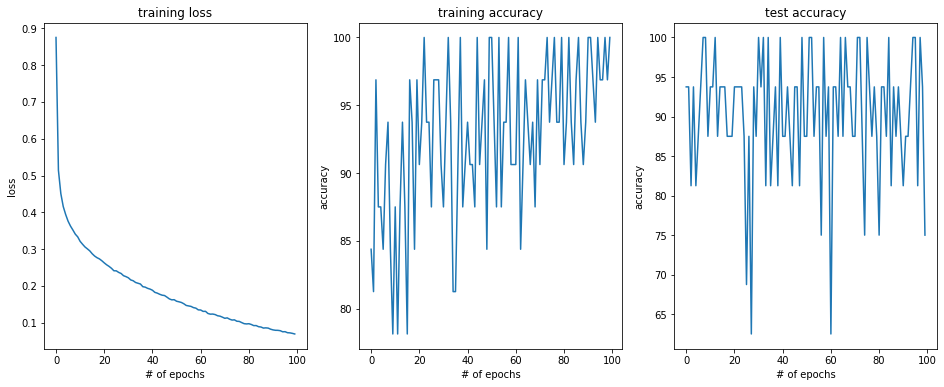

In [ ]:
model=MLP(ResBlock).to(device)
print(model)


import torch.optim as optim


#Training
num_epochs=100
bs=64 #generally powers of 2
lr=0.01


#data Loading
dLoader_train = DataLoader(fashionmnist_train,bs, shuffle=True)
dLoader_test = DataLoader(fashionmnist_test,bs, shuffle=True)


#Loss
loss = nn.CrossEntropyLoss()

#optimizer
optimizer=optim.SGD(model.parameters(),lr)
    
losses=[]
losses_test=[]
accuracy_train=[]    
accuracy_test=[]
temp_Accuracy=0

#accuracy function
avg_accuracy=0
count=0
def accuracy_func(predictions,target,isAvg=0):
    correct=0
    global avg_accuracy
    global count
    global temp_Accuracy
    if(isAvg==1):
        avg_accuracy=avg_accuracy/count
        return avg_accuracy*100
    
    if(count==(len(dLoader_train)*num_epochs)):   
        temp_Accuracy=0
        avg_accuracy=0
        count=0
    for i in range(0,len(target),1):
        if(target[i]==predictions[i]):
            correct=correct+1
    accuracy=correct/len(target)
    temp_Accuracy=accuracy
    avg_accuracy+=accuracy
    count=count+1
  
    

#training data
model.train()
for epoch in range(num_epochs):
    ll=0
    #for training
    for i,(x_batch,y_batch) in enumerate(dLoader_train):
        optimizer.zero_grad()
        y_hat=model(x_batch.to(device))
        _,predicted=torch.max(y_hat.data,1)   
        accuracy_func(predicted,y_batch.to(device))
        lossVal=loss(y_hat,y_batch.to(device))  
        lossVal.backward()
        optimizer.step()
        ll +=lossVal
    print(f'loss training {lossVal}')
    losses.append(ll.item()/len(dLoader_train))
    accuracy_train.append(temp_Accuracy*100)
        
print("Average Accuracy of training data",accuracy_func(0,0,1),"%")
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.title("training loss")
plt.plot(losses[:])
plt.ylabel('loss')
plt.xlabel('# of epochs')

plt.subplot(1,3,2)
plt.title("training accuracy")
plt.plot(accuracy_train[:])
plt.ylabel('accuracy')
plt.xlabel('# of epochs')


#test data / by using trained model
with torch.no_grad():
    model.eval()
    for epoch in range(num_epochs):
        ll_test=0
        for i,(xbatch,ybatch) in enumerate(dLoader_test):
                yhat=model(xbatch.to(device))
                _,predictions=torch.max(yhat.data,1)
                accuracy_func(predictions,ybatch.to(device))
                lossValtest=loss(yhat,ybatch.to(device))
                ll_test+=lossValtest
        print(f'loss test {lossValtest}')
        losses_test.append(ll_test.item()/len(dLoader_test))
        accuracy_test.append(temp_Accuracy*100)
        
    plt.subplot(1,3,3)  
    plt.title("test accuracy")
    plt.plot(accuracy_test[:])
    plt.ylabel('accuracy')
    plt.xlabel('# of epochs')
        
print("Average Accuracy of test data",accuracy_func(0,0,1),"%") 



# Step 6


**Conclusion and Comments:**

To obtain a good accurate rate and good loss value we have tried many different combinations of hyperparameters. At first, we set the epoch size to 30 but the loss results were not low enough that's why we have increased the epoch size to 100. In the end, we reduced the training loss value to 0.02, increased the training accuracy to 93%, and test accuracy to 89%. Since the training accuracy is slightly higher than test accuracy and both of them have great results, we understand that our model is implemented correctly . In addition to this, if we compare the results of this model with Problem 1 - Assignment B's results, we can clearly say that the loss values of this model (MLP) are significantly less than Problem 1 - Assignment B's loss values and the accuracies are about 10 percent higher (Problem 1 Assignment B Average Training Accuracy= 80% - Problem 3 Assignment A  Average Training Accuracy= 93% // Problem 1 Assignment B Average Test Accuracy= 82% - Problem 3 Assignment b Average Test Accuracy= 89.67%). As a result, we understand that the non-linearity feature MLP is worked better than Single NN.

